In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import joblib

In [12]:
data_path = Path("../data/processed/cleaned_gravity_speed_data.csv")
df = pd.read_csv(data_path)

print(f"Loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded: 1000 rows, 9 columns


In [13]:
df.head()

,mass_kg,radius_m,velocity_m_s,gravitational_dilation,velocity_dilation,combined_dilation,time_far_s,time_near_s,time_difference_s
0,6.620184e+29,5.356206e+09,8.128375e+07,1.0,1.038859,0.962595,1.0,0.962595,0.037405
1,8.862898e+29,8.749384e+09,1.207812e+08,1.0,1.092449,0.915374,1.0,0.915374,0.084626
2,2.994138e+29,2.869731e+09,6.245075e+07,1.0,1.022398,0.978093,1.0,0.978093,0.021907
3,4.302086e+29,6.169629e+09,1.997366e+08,1.0,1.340231,0.746140,1.0,0.746140,0.253860
4,3.116746e+29,2.609683e+09,1.579006e+08,1.0,1.176087,0.850277,1.0,0.850277,0.149723


In [14]:
G = 6.67430e-11
c = 299_792_458

def gravitational_time_dilation(mass_kg, radius_m):
    return np.sqrt(1 - (2 * G * mass_kg) / (radius_m * c**2))

def velocity_time_dilation(velocity_m_s):
    return np.sqrt(1 - (velocity_m_s**2) / c**2)

In [15]:
df["gravitational_dilation_theory"] = gravitational_time_dilation(df["mass_kg"], df["radius_m"])
df["velocity_dilation_theory"] = velocity_time_dilation(df["velocity_m_s"])
df["combined_dilation_theory"] = df["gravitational_dilation_theory"] * df["velocity_dilation_theory"]

In [16]:
model_path = Path("../models/rf_model.joblib")
model = joblib.load(model_path)

target_col = "combined_dilation_theory"
feature_cols = [
	"mass_kg", "radius_m", "velocity_m_s",
	"gravitational_dilation", "velocity_dilation", "combined_dilation",
	"time_far_s", "time_near_s"
]
X = df[feature_cols]
df[f"{target_col}_pred"] = model.predict(X)

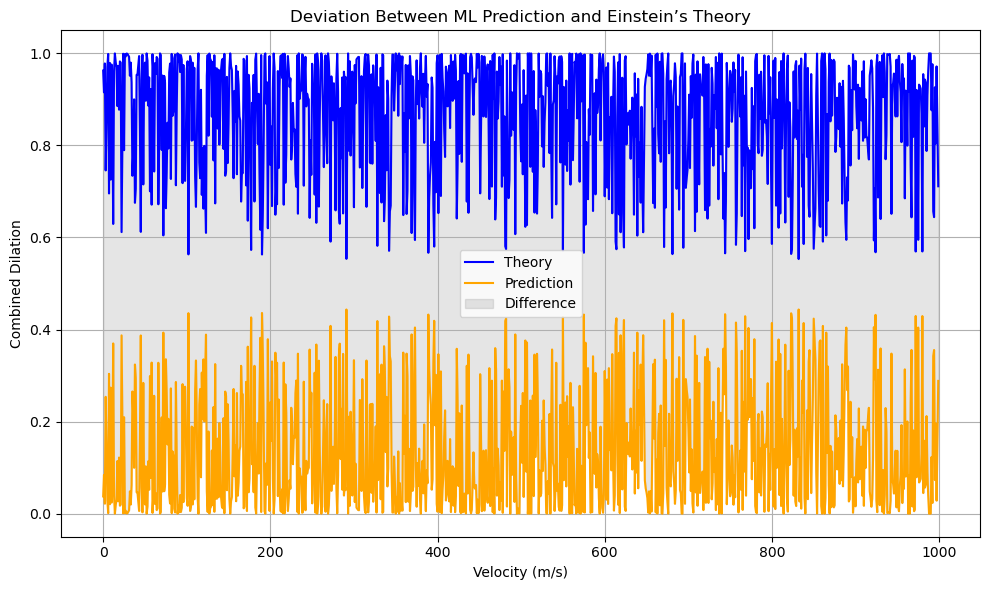

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(df["combined_dilation_theory"], label="Theory", color="blue")
plt.plot(df["combined_dilation_theory_pred"], label="Prediction", color="orange")
plt.fill_between(range(len(df)), df["combined_dilation_theory"], df["combined_dilation_theory_pred"], 
                 color="gray", alpha=0.2, label="Difference")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Combined Dilation")
plt.title("Deviation Between ML Prediction and Einstein’s Theory")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
rmse = root_mean_squared_error(df["combined_dilation_theory"], df["combined_dilation_theory_pred"])
mae = mean_absolute_error(df["combined_dilation_theory"], df["combined_dilation_theory_pred"])
r2 = r2_score(df["combined_dilation_theory"], df["combined_dilation_theory_pred"])

print(f"📊 Evaluation vs Theory:")
print(f"  - RMSE: {rmse:.6f}")
print(f"  - MAE:  {mae:.6f}")
print(f"  - R²:   {r2:.6f}")

📊 Evaluation vs Theory:
  - RMSE: 0.770418
  - MAE:  0.727326
  - R²:   -35.716642
